In [1]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
from io import BytesIO
import random
from zipfile import ZipFile

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from DepthData import DepthDataset
from DepthData import Augmentation
from DepthData import ToTensor

In [2]:
os.getcwd()

'/workspace'

In [3]:
# from zipfile import ZipFile
# zf = ZipFile('/workspace/FILENAME', 'r')
# zf.extractall('/workspace/')
# zf.close()

In [4]:
# traincsv = shuffle(traincsv, random_state=0)
traincsv=pd.read_csv('/workspace/data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)


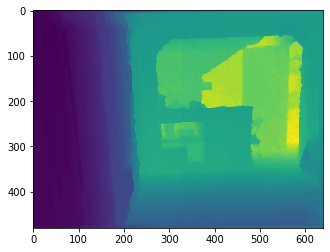

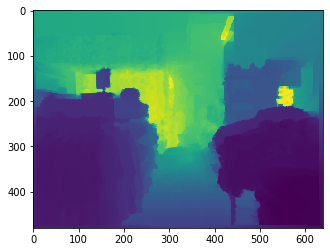

<Figure size 432x288 with 0 Axes>

In [5]:
depth_dataset = DepthDataset(traincsv=traincsv,
                                    root_dir='/workspace/')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size, sample['depth'].size)


    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()


    if i == 1:
        plt.show()
        break

In [6]:
depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
depth_dataset

In [7]:
batch_size=4
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size, shuffle=True)
train_loader

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [9]:
images

'image'

In [10]:
from model_dense import Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        #interpolate x from x.size to larger size(concat_with.shape=(C,H,W))
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=2208, decoder_width = 0.25):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)

        self.up1 = UpSample(skip_input=features//1 + 384, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 192, output_features=features//4)
#         self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//8)
        self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//16)
        self.up4 = UpSample(skip_input=features//8 +  96, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[11]
        x_d0 = self.conv2(x_block4)
        #15x20 to 15x20
        x_d1 = self.up1(x_d0, x_block3)
        #15x20 to 30x40
        x_d2 = self.up2(x_d1, x_block2)
        #30x40 to 60x80
        x_d3 = self.up3(x_d2, x_block1)
        #60x80 to 120x160
#         x_d4 = self.up4(x_d3, x_block0)
        #120x160 to 240x320
        return self.conv3(x_d3)
       # return self.conv3(x_d4)

#Encoder uses the densenet_161 pretrained model
#following encoder encodes the image and store the features output from each output of layer
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.densenet161( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [13]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [14]:
import torchvision.models as models
original_model = models.resnet18 ( pretrained=True )
original_model.layer1
res50_model = models.resnet50(pretrained=True)
res50_conv = nn.Sequential(*list(res50_model.children())[:-2])
res50_conv[10]
# for i,(k, v) in enumerate(original_model.features._modules.items()): 
#     print(k,i+1)
# for i,(k, v) in enumerate(original_model.items()): 
#     print(k,i+1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.0MB/s]


IndexError: index 10 is out of range

In [15]:
pip install tensorboardX


     |################################| 204kB 3.6MB/s eta 0:00:01
     |################################| 1.3MB 22.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install kornia

     |################################| 122kB 3.6MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2
import kornia 

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIM(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)

In [24]:
import matplotlib
import matplotlib.cm
import numpy as np


def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [ ]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output
    

In [ ]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
from tensorboardX import SummaryWriter

# from data import getTrainingTestingData
# from utils import AverageMeter, DepthNorm, colorize

model = Model().cuda()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.load_state_dict(torch.load('/workspace/3.pth'))

#model = Model()
print('Model created.')


epochs=2
lr=0.0001
batch_size=16

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam( model.parameters(), lr )

# Start training...
for epoch in range(epochs):
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        #Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
       
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 5 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            #writer.add_scalar('Train/Loss', losses.val, niter)
            
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)    
#         if i % 300 == 0:
#             LogProgress(model, writer, test_loader, niter)

#     # Record epoch's intermediate results
#     LogProgress(model, writer, test_loader, niter)
#     writer.add_scalar('Train/Loss.avg', losses.avg, epoch)




Let's use 4 GPUs!
Model created.
Epoch: [0][0/3168]	Time 1.703 (1.703)	ETA 1:29:54	Loss 0.5291 (0.5291)
Epoch: [0][5/3168]	Time 1.243 (8.227)	ETA 1:05:31	Loss 0.5301 (0.5284)
Epoch: [0][10/3168]	Time 1.197 (14.320)	ETA 1:03:01	Loss 0.5247 (0.5276)
Epoch: [0][15/3168]	Time 1.243 (20.394)	ETA 1:05:20	Loss 0.5234 (0.5263)
Epoch: [0][20/3168]	Time 1.234 (26.510)	ETA 1:04:43	Loss 0.5237 (0.5260)
Epoch: [0][25/3168]	Time 1.201 (32.589)	ETA 1:02:55	Loss 0.5220 (0.5257)
Epoch: [0][30/3168]	Time 1.234 (38.635)	ETA 1:04:31	Loss 0.5246 (0.5253)
Epoch: [0][35/3168]	Time 1.196 (44.743)	ETA 1:02:28	Loss 0.5245 (0.5251)
Epoch: [0][40/3168]	Time 1.196 (50.828)	ETA 1:02:19	Loss 0.5269 (0.5250)
Epoch: [0][45/3168]	Time 1.269 (57.016)	ETA 1:06:03	Loss 0.5237 (0.5250)
Epoch: [0][50/3168]	Time 1.316 (63.056)	ETA 1:08:24	Loss 0.5301 (0.5252)
Epoch: [0][55/3168]	Time 1.216 (69.096)	ETA 1:03:03	Loss 0.5251 (0.5252)
Epoch: [0][60/3168]	Time 1.195 (75.114)	ETA 1:01:55	Loss 0.5278 (0.5254)
Epoch: [0][65/3168]	Ti

In [20]:
model = Model().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/workspace/3.pth'))
model.eval()


DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): DenseNet(
        (features): Sequential(
          (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu0): ReLU(inplace=True)
          (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (denseblock1): _DenseBlock(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace=True)
              (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu2): ReLU(inplace=True)
              (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

for sample_batched1  in (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    break

    

In [ ]:
x=outtt.detach().cpu().numpy()

In [ ]:
x.shape
x=x.reshape(120,160)


In [ ]:
x.shape

In [ ]:
torch.cuda.empty_cache()

In [ ]:
sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0).shape

In [ ]:
plt.imshow(x)
plt.figure()
plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))